# Regresión logística

## Ejemplo Didáctico

En este notebook vamos a llevar a cabo la implementación de la regresión logísitica en un caso de uso sencillo pero con mucho que aprender. Vamos a usar algunas buenas prácticas de programar en un jupyter-notebook. 

## Obtener dependencias
Cuando no tengamos dependencias disponibles tenemos que descargarlas a traves de pip.

In [1]:
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn

### Librerías
Aquí vamos a incluir todas las dependencias del código que tengamos con las librerías externas. 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import pickle
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV # Creación de conjuntos aleatorios. Y optimización de hiperparámetros
from sklearn.linear_model import LogisticRegression # Modelo de clasificacion.
from sklearn import datasets # Información
# Procesamiento de datos:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Metricas de evaluación.
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    roc_curve,
)

### Constants
Aquí declaramos las constantes que vayamos a utilizar en el código. 

In [3]:
DATASET_NAME = "mnist_784"
SEED = 42
processor_filename = './processor.pkl'
model_filename = './modelo_clf2.pkl'


### Funciones
En caso de crear alguna función, es necesario que estén juntas para facilitar la lectura del código. 

In [4]:
def flatten_img(img):
    return img[:, :, 0].reshape(1, 28*28)[0]

def get_image_info(filepath):
    image = matplotlib.image.imread(filepath)
    new_image = flatten_img(image)
    transformed_img = (pd.Series(new_image).astype('int')-255).abs()
    return transformed_img

def plot_img(df, name):
    pixel_columns = [col for col in df if 'pixel' in col]
    img_representation = df[pixel_columns].iloc[0].to_numpy().reshape(28,28)
    plt.figure(figsize=(5,5))
    sns.heatmap(img_representation, cmap=colormap, fmt=".0f", annot=True, annot_kws={"size": 4}, linewidth=.5)
    plt.title(f'Representación matricial de {name}')
    plt.axis("off")
    plt.show()
    
def get_features_as_df(transformed_img, img_name, data, plot=True):
    img_df = pd.DataFrame()
    img_df[img_name] = transformed_img
    img_df = img_df.T
    img_df.columns = data['feature_names']
    img_df['mean_px_val'] = img_df.mean(axis=1)
    img_df['non_zero_elements'] = (img_df.drop('mean_px_val', axis=1) > 0).mean(axis=1)
    if plot:
        plot_img(img_df, img_name)
    return img_df

### Código
Una vez que definimos las dependencias, las constantes y las funciones podemos comenzar a procesar los datos a través del código

### Configuración
Aquí vamos a poner configuraciones en general

In [5]:
warnings.filterwarnings('ignore')
colormap = matplotlib.cm.binary

#### Lectura de datos

In [6]:
data = datasets.fetch_openml(DATASET_NAME, parser='auto')

#### EDA

In [7]:
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
print(data.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

#### Caso de uso inventado: Clasificación binaria
Necesitamos un modelo donde prediga "bajo", si el valor del número está por debajo de 5, y prediga "alto" si el valor es mayor o igual a 5.

In [9]:
x = data['data']
y = data['target']
xy = x.copy()
xy['tag'] = y

# Business rule, Model that a number is greater than or equal to 5
# 'target' is the prediction
xy['target'] = (xy['tag'].astype('int') >= 5).astype('int')
xy['mean_px_val'] = x.mean(axis=1)
xy['non_zero_elements'] = (x > 0).mean(axis=1)

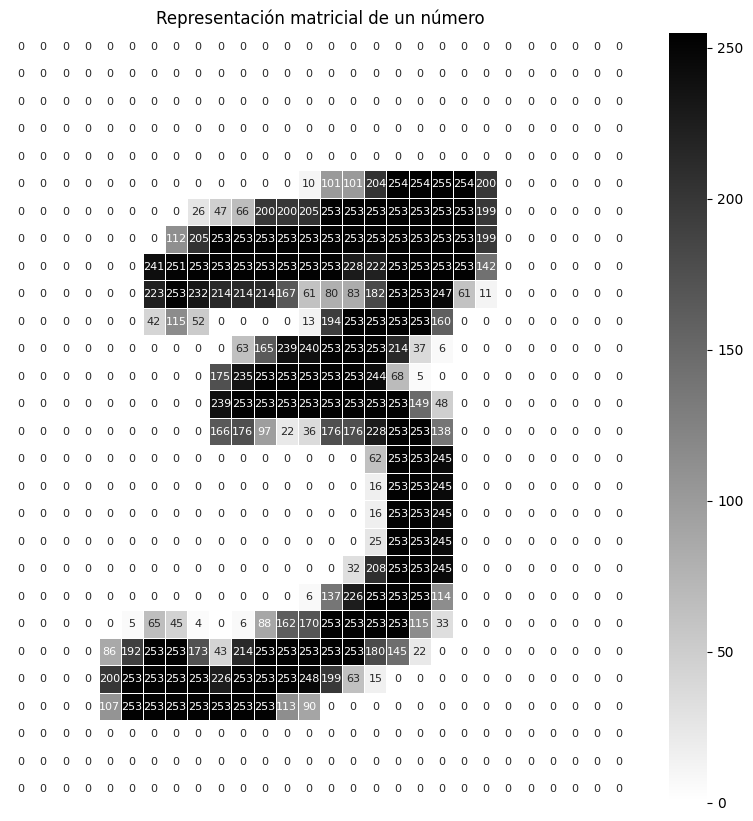

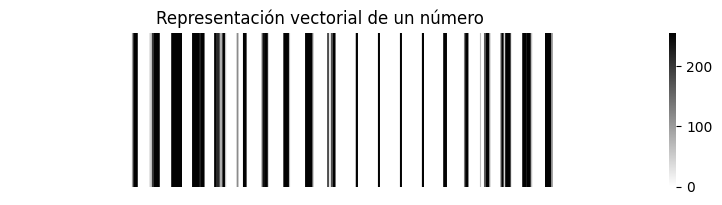

In [10]:
random_index = np.random.randint(0, x.shape[0])
random_digit = x.loc[random_index] 
random_digit_img_representation = random_digit.to_numpy().reshape(28,28)
plt.figure(figsize=(10,10))
sns.heatmap(random_digit_img_representation, cmap=colormap, fmt=".0f", annot=True, annot_kws={"size": 8}, linewidth=.5)
plt.title('Representación matricial de un número')
plt.axis("off")
plt.show()

plt.figure(figsize=(10,2))
sns.heatmap(random_digit.to_numpy().reshape(1, 28*28), cmap=colormap)
plt.title('Representación vectorial de un número')
plt.axis("off")
plt.show()



<Axes: title={'center': 'Distribución del valor promedio de los pixeles'}, xlabel='mean_px_val', ylabel='tag'>

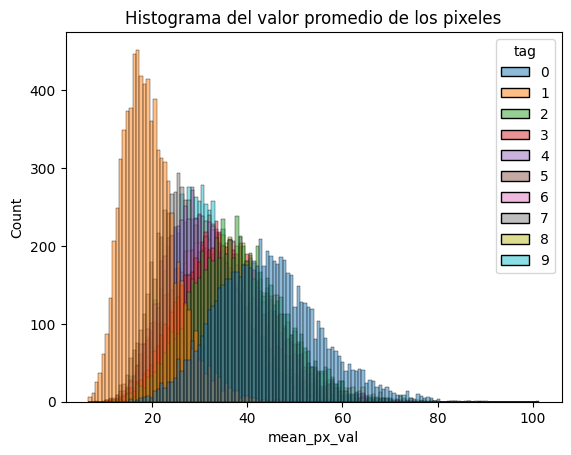

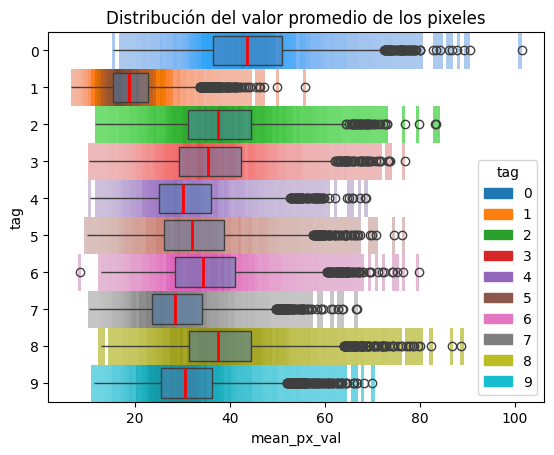

In [11]:
plt.title('Histograma del valor promedio de los pixeles')
sns.histplot(xy, x='mean_px_val', hue='tag')
plt.figure()

plt.title('Distribución del valor promedio de los pixeles')
sns.histplot(xy, x='mean_px_val', y='tag', hue='tag')
sns.boxplot(
    data=xy, 
    x="mean_px_val", 
    y="tag",
    showcaps=False,
    flierprops={"marker": "o"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
)

<Axes: title={'center': 'Distribución de la proporción de elementos mayores a 0.'}, xlabel='non_zero_elements', ylabel='tag'>

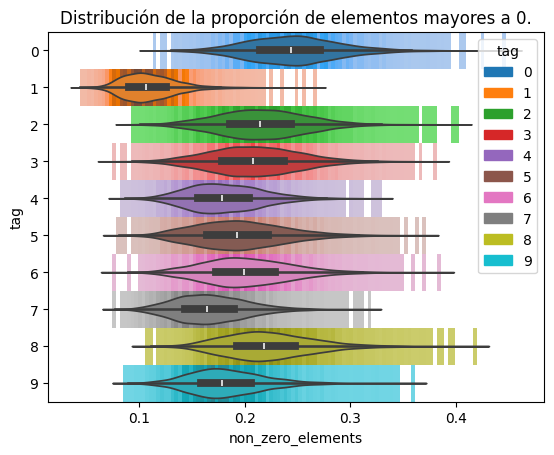

In [12]:
plt.title('Distribución de la proporción de elementos mayores a 0.')
sns.histplot(xy, x='non_zero_elements', y='tag', hue='tag')
sns.violinplot(
    data=xy, 
    x="non_zero_elements", 
    y="tag",
    hue='tag',
)

<Axes: xlabel='non_zero_elements', ylabel='mean_px_val'>

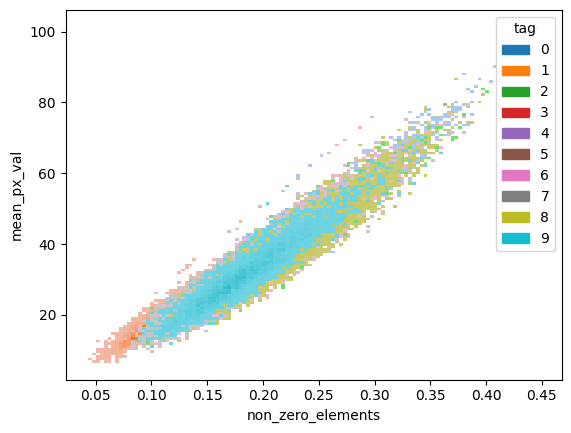

In [13]:
sns.histplot(xy, x='non_zero_elements', y='mean_px_val', hue='tag')

<Axes: xlabel='tag', ylabel='count'>

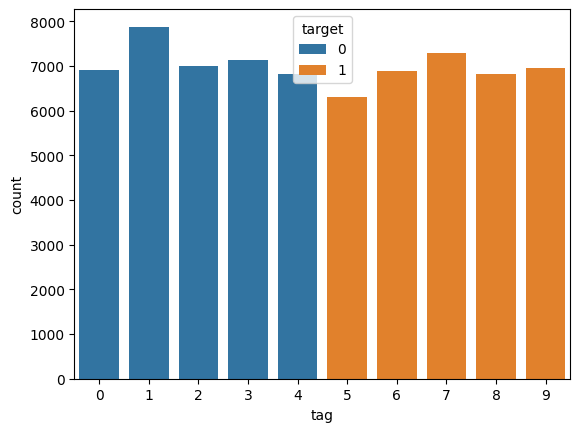

In [14]:
sns.countplot(xy, x='tag', hue='target')

<Axes: xlabel='target', ylabel='count'>

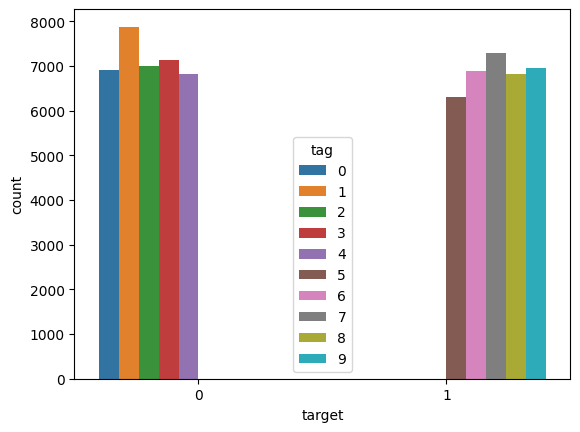

In [15]:
# Representaciòn de las características asociadas a la variable de respuesta.
sns.countplot(xy, x='target', hue='tag')

##### Separación en conjuntos
Vamos a hacer la separación de los datos, en distintos conjuntos de datos: 
- entrenamiento 
- prueba

In [16]:
train_set, test_set = train_test_split(xy, train_size=0.7, random_state=SEED)
test_set, val_set = train_test_split(test_set, train_size=0.5, random_state=SEED)
non_predictor_columns = ['target', 'tag']

In [17]:
x_train_raw = train_set.drop(non_predictor_columns, axis=1)
y_train_raw = train_set['target']

x_val_raw = val_set.drop(non_predictor_columns, axis=1)
y_val_raw = val_set['target']

x_test_raw = test_set.drop(non_predictor_columns, axis=1)
y_test_raw = test_set['target']

#### Preprocesamiento de datos 
Aquí vamos a aplicar ciertas técnicas para dejar los datos similares a lo que buscamos (Limpieza/filtros/etc.)

In [18]:
x_train_raw[['mean_px_val', 'non_zero_elements']]

,mean_px_val,non_zero_elements
68681,52.857143,0.280612
19961,46.436224,0.213010
11040,27.843112,0.183673
27673,24.635204,0.173469
22876,33.642857,0.192602
...,...,...
37194,29.834184,0.173469
6265,40.016582,0.207908
54886,16.234694,0.098214
860,43.247449,0.237245


In [19]:
#pca = PCA(n_components=64)
pixel_columns = [col for col in x_train_raw.columns if 'pixel' in col]

ct = ColumnTransformer([
    ("dim_reduction", PCA(n_components=64), pixel_columns),
    ("numerical_preprocess", MinMaxScaler(), ['mean_px_val', 'non_zero_elements'])
])

pipe = Pipeline([('feature_processor', ct), ('normalizer', Normalizer())])
pipe.fit(x_train_raw)

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('dim_reduction',
                                                  PCA(n_components=64),
                                                  ['pixel1', 'pixel2', 'pixel3',
                                                   'pixel4', 'pixel5', 'pixel6',
                                                   'pixel7', 'pixel8', 'pixel9',
                                                   'pixel10', 'pixel11',
                                                   'pixel12', 'pixel13',
                                                   'pixel14', 'pixel15',
                                                   'pixel16', 'pixel17',
                                                   'pixel18', 'pixel19',
                                                   'pixel20', 'pixel21',
                                                   'pixel22', 'pixel23',
                                                   'pixel24', 'pixel25',
                                                   'pixel26', 'pixel27',
                                                   'pixel28', 'pixel29',
                                                   'pixel30', ...]),
                                                 ('numerical_preprocess',
                                                  MinMaxScaler(),
                                                  ['mean_px_val',
                                                   'non_zero_elements'])])),
                ('normalizer', Normalizer())])

In [20]:
#Salvemos el proceso de transformar variables.

with open(processor_filename, 'wb') as file:
    pickle.dump(pipe, file)


In [21]:
x_train_new = pipe.transform(x_train_raw)
x_val_new = pipe.transform(x_val_raw)
x_test_new = pipe.transform(x_test_raw)

##### Entrenamiento del modelo
Vamos ahora a entrenar el modelo con la información del conjunto de entrenamiento

In [22]:
# Definimos el modelo que queremos entrenar
model = LogisticRegression()

# Encontramos lista de parametros relevantes para el modelo
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)

# Hacemos una optimizacion de hiperparametros, con un conjunto pequeño.
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid, 
    n_jobs=-1, 
    scoring='roc_auc', 
    error_score=0, 
)

In [23]:
grid_result = grid_search.fit(x_val_new, y_val_raw)
#grid_result.cv_results_

In [24]:
best_params = grid_result.best_estimator_.get_params()

In [25]:
clf = LogisticRegression(**best_params)
clf.fit(x_train_new, y_train_raw)

LogisticRegression(C=10, solver='newton-cg')

In [26]:
# Salvemos modelo
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)

##### Evaluemos el entrenamiento
Vamos entonces a evaluar el desempeño del modelo, respecto al conjunto de entrenamiento. 



In [27]:
pred_train = clf.predict_proba(x_train_new)[:, 1]
pred_val = clf.predict_proba(x_val_new)[:, 1]
pred_test = clf.predict_proba(x_test_new)[:, 1]

In [28]:
roc_auc_score(y_train_raw, pred_train)

0.9045313028022246

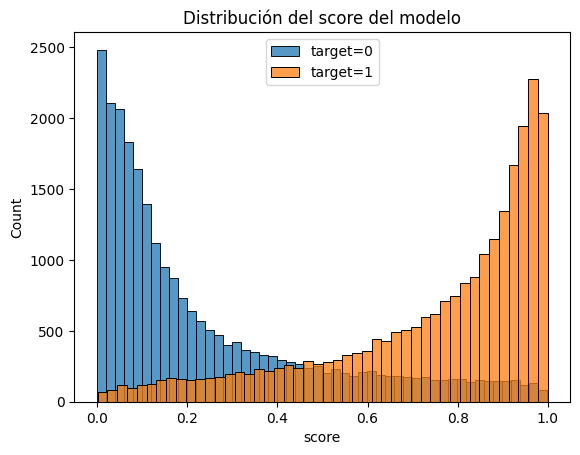

In [29]:
sns.histplot(pred_train[y_train_raw==0], label='target=0')
sns.histplot(pred_train[y_train_raw==1], label='target=1')
plt.title('Distribución del score del modelo')
plt.xlabel('score')
plt.legend()

In [30]:
visual_cutpoint = 0.6

In [31]:
accuracy_score(y_train_raw, pred_train > visual_cutpoint)

0.8238163265306122

In [32]:
precision_score(y_train_raw, pred_train > visual_cutpoint)

0.8551135044798291

In [33]:
recall_score(y_train_raw, pred_train > visual_cutpoint)

0.7696807621594518

In [34]:
f1_score(y_train_raw, pred_train > visual_cutpoint)

0.8101510786620632

In [35]:
print(classification_report(y_train_raw, pred_train > visual_cutpoint))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     25068
           1       0.86      0.77      0.81     23932

    accuracy                           0.82     49000
   macro avg       0.83      0.82      0.82     49000
weighted avg       0.83      0.82      0.82     49000



<Axes: >

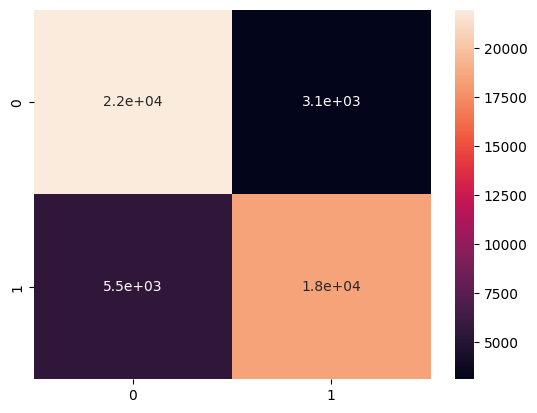

In [36]:
sns.heatmap(confusion_matrix(y_train_raw, pred_train > visual_cutpoint), annot=True)

##### Evaluemos la prueba
Vamos entonces a evaluar el desempeño del modelo, respecto al conjunto de prueba. 

In [37]:
roc_auc_score(y_test_raw, pred_test)

0.9012986888594356

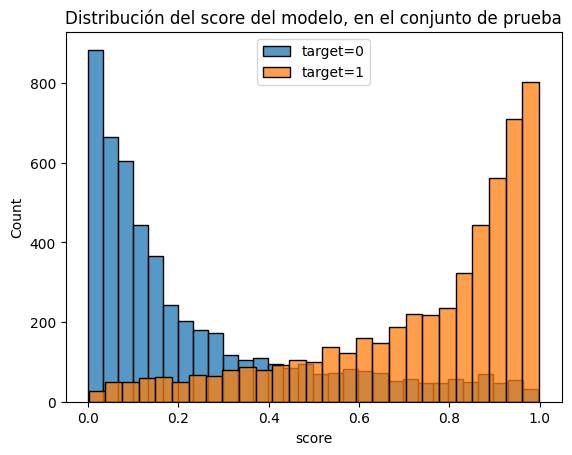

In [38]:
sns.histplot(pred_test[y_test_raw==0], label='target=0')
sns.histplot(pred_test[y_test_raw==1], label='target=1')
plt.title('Distribución del score del modelo, en el conjunto de prueba')
plt.xlabel('score')
plt.legend()

In [39]:
print(classification_report(y_test_raw, pred_test > visual_cutpoint))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5253
           1       0.86      0.76      0.81      5247

    accuracy                           0.82     10500
   macro avg       0.82      0.82      0.82     10500
weighted avg       0.82      0.82      0.82     10500



<Axes: >

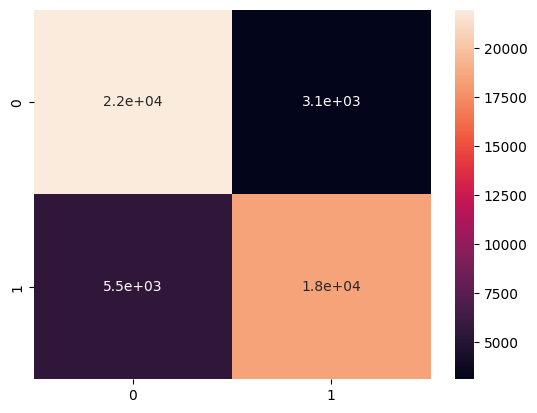

In [40]:
sns.heatmap(confusion_matrix(y_train_raw, pred_train > visual_cutpoint), annot=True)

#### Conclusión: 
Entrenar un modelo es sencillo. Lo que lo hará mejor o peor depende completamente de:
1) El tratamiento de datos y la información disponible para la predicción.
2) El hecho de ver qué hiperparámetros lo mejoran (optimización de hiperparámet

### EXTRA: Probemos el modelo...

In [41]:
imgs_path = "../../data/handwritten_examples/"
all_imgs = os.listdir(imgs_path)
desired_images = [img for img in all_imgs if 'bmp' in img]

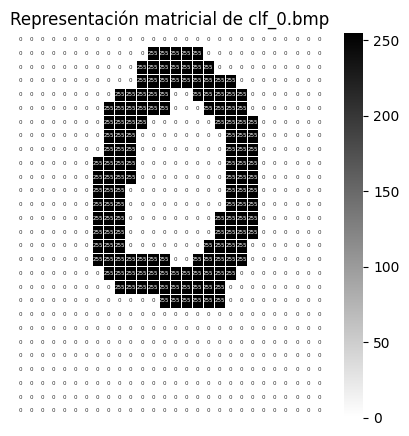

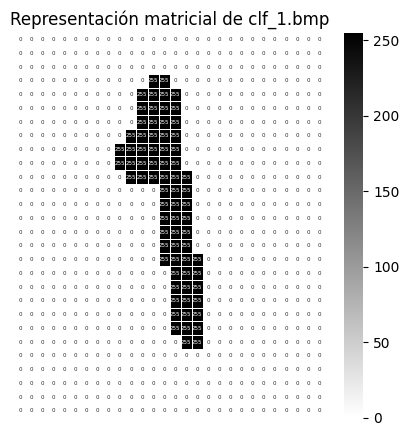

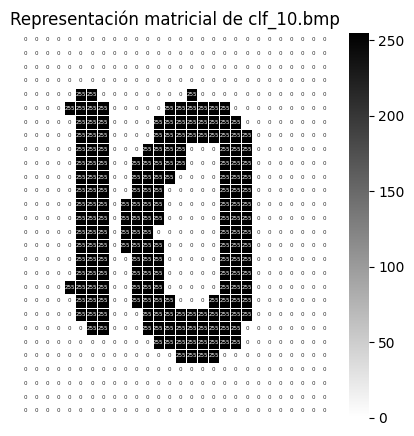

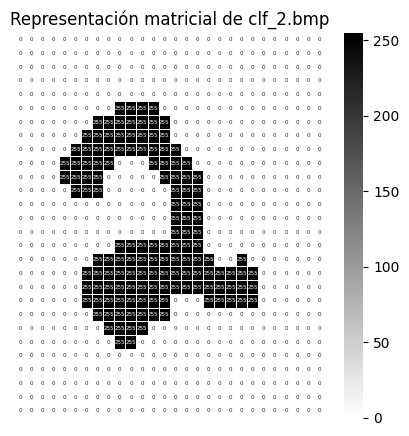

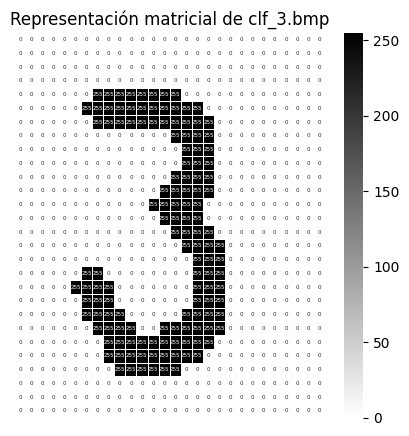

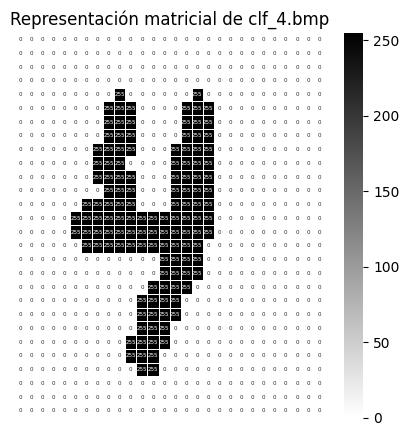

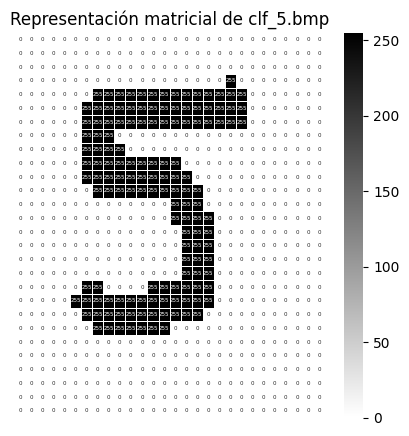

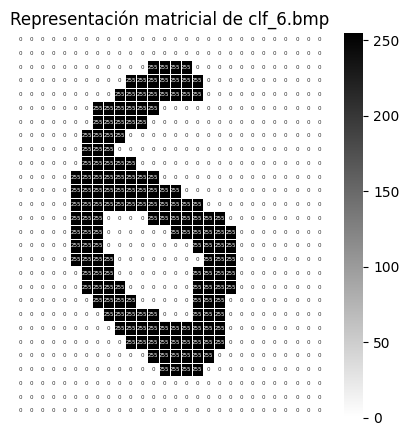

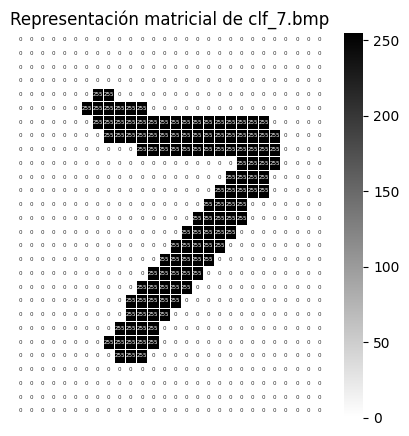

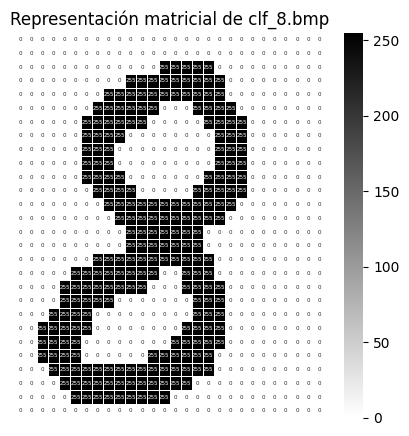

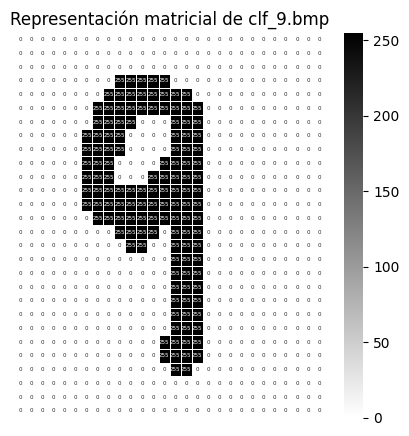

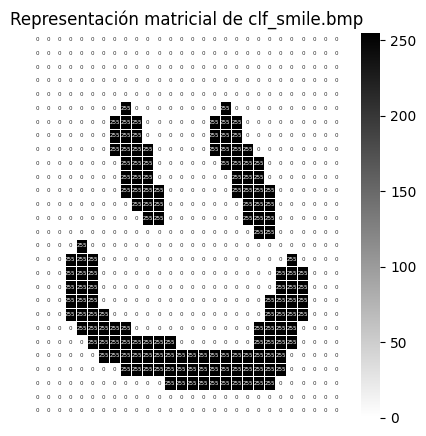

In [42]:
production_images_df = []
for img in desired_images:
    img_path = os.path.join(imgs_path, img)
    transformed_img = get_image_info(img_path)
    img_df = get_features_as_df(transformed_img, img_name=img, data=data)
    production_images_df.append(img_df)

In [43]:
production_images_df_all = pd.concat(production_images_df)

In [44]:
with open(processor_filename, 'rb') as f:
    number_transformer = pickle.load(f)
    
with open(model_filename, 'rb') as f:
    final_model = pickle.load(f)

In [45]:
img_df_processed = number_transformer.transform(production_images_df_all)

In [46]:
production_images_df_all['response'] = final_model.predict_proba(img_df_processed)[:, 1]

In [47]:
results = production_images_df_all[['response']]

In [48]:
results['decision'] = (results['response'] > visual_cutpoint).astype('int')

In [49]:
results

,response,decision
clf_0.bmp,0.251055,0
clf_1.bmp,0.307652,0
clf_10.bmp,0.384520,0
clf_2.bmp,0.629976,1
clf_3.bmp,0.027667,0
clf_4.bmp,0.475241,0
clf_5.bmp,0.895279,1
clf_6.bmp,0.956783,1
clf_7.bmp,0.146728,0
clf_8.bmp,0.720774,1
